This work will train the dataset in [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) for class activation map

# Package

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras.layers as tfl

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2

# data download and preprocessing

In [4]:
splits, info = tfds.load('cats_vs_dogs', split=['train[:80%]','train[80%:90%]', 'train[90%:]'], as_supervised=True,
                   with_info=True, data_dir='./cats_vs_dogs', download=False)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs/cats_vs_dogs/4.0.0.incompleteFXTAUB/cats_vs_dogs-train.tfrecord*...:   0%|          | 0…

Dataset cats_vs_dogs downloaded and prepared to ./cats_vs_dogs/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [5]:
train_data, validation_data, test_data = splits

In [6]:
# formate and normalize the image
def format_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.
    image = tf.image.resize(image, (300, 300))
    
    return image, label

In [39]:
# get the batch dataset
batch_size = 32
train_dataset_batch = train_data.map(format_image).shuffle(1024).batch(batch_size).repeat()
validation_dataset_batch = validation_data.map(format_image).batch(batch_size)
test_dataset_batch = test_data.map(format_image).batch(batch_size)

# Define a classifier model

In [8]:
def classifier_model(inputs):
    
    x = tfl.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='SAME')(inputs)
    x = tfl.MaxPooling2D((2, 2))(x)
    
    x = tfl.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tfl.MaxPooling2D((2, 2))(x)
    
    x = tfl.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tfl.MaxPooling2D((2, 2))(x)
    
    x = tfl.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='SAME')(x)
    x = tfl.GlobalAveragePooling2D()(x)
    
    output = tfl.Dense(1, 'sigmoid')(x) # binary classifier
    
    model = tf.keras.Model(inputs=inputs, outputs=output)
    
    return model

In [28]:
# compile model
inputs = tfl.Input((300, 300, 3))
model = classifier_model(inputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        1849

In [29]:
total_num_example = info.splits['train'].num_examples
train_num_example = len(train_data)
validation_num_example = len(validation_data)
test_num_example = total_num_example - validation_num_example - train_num_example

In [30]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

In [40]:
step_per_train = train_num_example // batch_size
validation_step = len(validation_data) // batch_size

model.fit(train_dataset_batch, epochs=25, steps_per_epoch=step_per_train, 
          validation_data=validation_dataset_batch, validation_steps=validation_step)

Epoch 1/25
581/581 [==============================] - 72s 121ms/step - loss: 0.5070 - acc: 0.7554 - val_loss: 0.5185 - val_acc: 0.7600
Epoch 2/25
581/581 [==============================] - 71s 123ms/step - loss: 0.5003 - acc: 0.7626 - val_loss: 0.5061 - val_acc: 0.7687
Epoch 3/25
581/581 [==============================] - 71s 123ms/step - loss: 0.4853 - acc: 0.7728 - val_loss: 0.4657 - val_acc: 0.7995
Epoch 4/25
581/581 [==============================] - 72s 124ms/step - loss: 0.4808 - acc: 0.7804 - val_loss: 0.5113 - val_acc: 0.7530
Epoch 5/25
581/581 [==============================] - 71s 122ms/step - loss: 0.4707 - acc: 0.7822 - val_loss: 0.4804 - val_acc: 0.7795
Epoch 6/25
581/581 [==============================] - 71s 122ms/step - loss: 0.4612 - acc: 0.7914 - val_loss: 0.4505 - val_acc: 0.8077
Epoch 7/25
581/581 [==============================] - 72s 123ms/step - loss: 0.4538 - acc: 0.7949 - val_loss: 0.6288 - val_acc: 0.7248
Epoch 8/25
581/581 [==============================] - 7

## Building the CAM model


In [43]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model = tf.keras.Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
# cam_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        1849

In [73]:
def show_cam(image_value, features, results):
    '''
    Displays the class activation map of an image

    Args:
      image_value (tensor) -- preprocessed input image with size 300 x 300
      features (array) -- features of the image, shape (1, 37, 37, 128)
      results (array) -- output of the sigmoid layer
    '''

    # there is only one image in the batch so we index at `0`
    features_for_img = features[0]
    prediction = results[0]

    # there is only one unit in the output so we get the weights connected to it
    class_activation_weights = gap_weights[:,0]

    # upsample to the image size
    class_activation_features = sp.ndimage.zoom(features_for_img, (300/37, 300/37, 1), order=2)
    
    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'dog' if round(results[0][0]) else 'cat'}")
    fig = plt.figure()
    # plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 3, 1)
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 3, 2)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 3, 3)
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

    return cam_output

In [70]:
# training features from the test_data
X_test = [x[0] for x in list(test_data)]

In [71]:
def convert_and_classify(image):

    # load the image
    # img = cv2.imread(image)
  
    # preprocess the image before feeding it to the model
    img = tf.image.resize(image, (300,300)) / 255.0
  
    # add a batch dimension because the model expects it
    tensor_image = np.expand_dims(img, axis=0)
  
    # get the features and prediction
    features,results = cam_model.predict(tensor_image)
    
    # generate the CAM
    return show_cam(tensor_image, features, results)

1/1 [==============================] - 0s 29ms/step
sigmoid output: [[0.7262411]]
prediction: dog


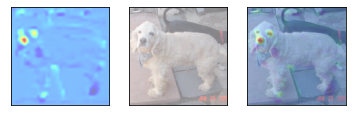

In [75]:
idx = 10
image = X_test[idx]
cam_output = convert_and_classify(image)

In [76]:
# model.save_weights('./weight.h5')